In [1]:
import os
import numpy as np
import numpy.random as rd

# read train set and qulifying set 
Xt = np.genfromtxt("train.csv", delimiter=",", dtype=np.int)
Xq = np.genfromtxt("qualifying.csv", delimiter=",", dtype=np.int)
print(Xt)

[[   2  566    1]
 [   2  750    2]
 [   2  391    1]
 ...
 [5498  565    2]
 [5498  648    2]
 [5498  651    2]]


There are so much number from 0 to 4 respectively:
[335499, 50169, 29623, 15138, 4212]


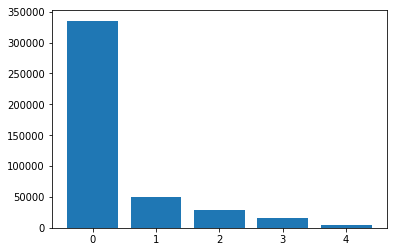

In [3]:
# data description
import matplotlib.pyplot as plt
List = [Xt[:,2][Xt[:,2]==i].shape[0] for i in range (np.max(Xt[:,2]+1))]
print('There are so much number from 0 to 4 respectively:')
print(List)
plt.bar(range(len(List)),List)
plt.show()

In [3]:
# data preparation
from sklearn import model_selection as ms
from scipy.sparse import coo_matrix
import pandas as pd   

Xt= Xt + np.array([0,0,1])
train_data,test_data=ms.train_test_split(Xt,test_size=0.2,random_state = 1)

n_users=max(Xt[:,0])+1
n_items=max(Xt[:,1])+1

def get_matrix(data):
    data_matrix=coo_matrix((data[:,2], (data[:,1], data[:,0])),shape=(n_items, n_users)).toarray()
    return (data_matrix)

train_data_matrix=get_matrix(train_data)
test_data_matrix=get_matrix(test_data)
print((train_data_matrix.shape))

def g(x):
    temp = x.copy()
    temp = np.mean(x[x>0])
    return temp

def f(x):
    temp = x.copy()
    # mean-centered ratings
    temp[temp > 0] = x[x > 0] - np.mean(x[x>0])
    return temp

train_data_dataframe = pd.DataFrame(train_data_matrix)
# print(train_data_dataframe)

print('')
train_data_mean = train_data_dataframe.apply(g,axis=1)
train_data_bias = train_data_dataframe.apply(f,axis=1)

print(train_data_mean.shape)
print(train_data_bias.shape)


(2080, 5499)

(2080,)
(2080, 5499)


In [4]:
# compute Similarity      
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

def compute_sim(data):
    A =  np.array(data)
    A_sparse = sparse.csr_matrix(A)
    sim_matrix = cosine_similarity(A_sparse)
    return (sim_matrix)

sim=compute_sim(train_data_bias)
np.savetxt('sim.csv', sim, delimiter = ',')

In [5]:
train_data_sim = np.loadtxt(open("sim.csv"),delimiter=",",skiprows=0)
train_data_sim[555][577]

0.19675591920935925

In [6]:
# compute the predicted data
import warnings
warnings.filterwarnings("ignore")

def k_neighbors(k,sim,train_mean,train_bias):
    r_hat_mat = np.zeros((n_items, n_users))

    for i in range(len(r_hat_mat)):
        sim[i][i]=0
        a = np.array(sim[:,i])
        neighbors_sim=-np.partition(-a,k)[:k]
        neighbors_ind=np.argpartition(-a,k)[:k]
        for j in range(r_hat_mat.shape[1]):
            r_hat_mat[i, j] = neighbors_sim.dot(train_bias[neighbors_ind][:,j]) 
            r_hat_mat[i, j] /= np.sum(np.abs(neighbors_sim)) 
        r_hat_mat[i] += train_mean[i]
    return (r_hat_mat)

r_hat = k_neighbors(5, train_data_sim, train_data_mean,train_data_bias.values)
np.savetxt('r_hat.csv', r_hat, delimiter = ',')
# print('result:\n {}\n'.format(r_hat))

In [7]:
print(r_hat.shape)
print(r_hat[565][2])

(2080, 5499)
1.5781018538826306


In [8]:
#Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(r_hat,r):
    r_hat[np.isnan(r_hat)]=0
    r_hat=r_hat[r.nonzero()].flatten()
    r=r[r.nonzero()].flatten()
    return sqrt(mean_squared_error(r_hat,r))

rmse_error=rmse(r_hat,test_data_matrix)
print ('Item-based CF RMSE: ' + str(rmse_error))  

Item-based CF RMSE: 0.5539183287044253


In [9]:
#train the whole train.csv
Xt_matrix=get_matrix(Xt)
Xt_dataframe = pd.DataFrame(Xt_matrix)
Xt_mean = Xt_dataframe.apply(g,axis=1)
Xt_bias = Xt_dataframe.apply(f,axis=1)
Xt_sim=compute_sim(train_data_bias)
Xt_hat = k_neighbors(10, Xt_sim, Xt_mean,Xt_bias.values)
print(Xt_hat.shape)
print(Xt_hat[565][2])

np.savetxt('Xt_hat.csv', Xt_hat, delimiter = ',')
Xt_hat = np.loadtxt(open("Xt_hat.csv"),delimiter=",",skiprows=0)
print(Xt_hat.shape)
print(Xt_hat[565][2])

(2080, 5499)
1.472084744721386
(2080, 5499)
1.472084744721386


In [10]:
# Xt_hat = np.loadtxt(open("Xt_hat.csv"),delimiter=",",skiprows=0)
# print(Xt_hat[565][2])

#for qualifying
Xt_hat[np.isnan(Xt_hat)]=0
Xt_hat[Xt_hat>0]-=1
Xt_hat[Xt_hat<0]=0
print(Xt_hat[565][2])

pred=[0 for i in range(len(Xq))]
for i in range(len(Xq)):
    pred[i]=Xt_hat[Xq[i,1],Xq[i,0]]

print(len(pred))
pred=np.array(pred)
pred=pred[:,np.newaxis]
print(pred.shape)

# np.c_[Xq,pred]
res=np.append(Xq,pred,axis=1)
print(res[6])

# # save in right format
np.savetxt("Result.csv", res, delimiter=",", newline="\n", encoding="utf-8")                 

0.47208474472138606
108660
(108660, 1)
[1.89800000e+03 7.42000000e+02 3.47433476e-01]
